In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix

# https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [3]:
path1 = 'https://gen10datafund2202.blob.core.windows.net/jedscontainer/911_Calls_For_Service.csv'
path2 = 'https://opendata.arcgis.com/api/v3/datasets/4f49eb825f564efa9a23cd103c4ba13b_0/downloads/data?format=csv&spatialRefId=4326'
detroit_911 = pd.read_csv(path1, thousands = ",")

## Clean the Data

In [4]:
detroit_df = detroit_911.copy()

null_values = detroit_911.isnull().sum()

detroit_df.drop(
    columns = [
        'incident_id',
        'zip_code',
        'oid',
        'respondingunit',
        'agency',
        'X',
        'Y',
        'longitude',
        'latitude',
        'incident_address',
        'block_id',
        'category'
    ], inplace = True)

mapped_priorities = detroit_df.groupby(by = ['priority'])['calldescription'].apply(lambda x: ', '.join(x)).reset_index()
mapped_priorities['calldescription'] = mapped_priorities['calldescription'].apply(lambda x: ", ".join(_.strip() for _ in set(x.split(","))))

### Fix Missing Priorities

In [5]:
priority_dict = {}
for priority in mapped_priorities['priority'].unique():
    priority_dict[priority] = mapped_priorities[(mapped_priorities.priority == priority)]['calldescription'].values.tolist()[0]

del priority_dict[" "]

def get_priority(current_priority, call_descrip):
    if current_priority != " ":
        return current_priority
    for key in priority_dict.keys():
        if call_descrip in priority_dict[key]:
            return key
        
    return 'FAIL'

detroit_df['new_priority'] = detroit_df.apply(lambda row: get_priority(row.priority, row.calldescription), axis = 1)

detroit_df.drop(columns = ['priority'], inplace = True)
detroit_df.rename(columns = {'new_priority': 'priority'}, inplace = True)


In [6]:
detroit_df.drop(columns = ['totaltime','totalresponsetime'], inplace = True)

### Convert timestamp to weekday

In [7]:
def return_weekday(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00').date()
    return dt.datetime.strftime(time, '%A')
    
detroit_df['weekday'] = detroit_df['call_timestamp'].apply(lambda x: return_weekday(x))

In [8]:
def get_daypart(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00')
    time = dt.datetime.strftime(time, '%H:%M:%S')
    if time < "06:00":
        time_of_day = "Early Morning"
    elif time >= "06:00" and time < "10:00":
        time_of_day = "Morning"
    elif time >= "10:00" and time < "12:00":
        time_of_day = "Late Morning"
    elif time >= "12:00" and time < "15:00":
        time_of_day = "Afternoon"
    elif time >= "15:00" and time < "18:00":
        time_of_day = "Late Afternoon"
    elif time >= "18:00" and time < "21:00":
        time_of_day = "Early Evening"
    elif time >= "21:00":
        time_of_day = "Evening"
    else:
        time_of_day = "FAILED"
    return time_of_day

detroit_df['day_part'] = detroit_df['call_timestamp'].apply(lambda x: get_daypart(x))


In [9]:
detroit_df.day_part.unique()

array(['Morning', 'Late Morning', 'Afternoon', 'Late Afternoon',
       'Early Evening', 'Evening', 'Early Morning'], dtype=object)

In [10]:
detroit_df.head()

,callcode,calldescription,call_timestamp,precinct_sca,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,825030,DISTURBANCE,2016/09/20 09:36:12+00,910A,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,811020,AUTO X UNK INJ / IMPAIRED,2016/09/20 09:46:32+00,1201,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,374030,RECOVER AUTO,2016/09/20 09:48:24+00,123B,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,825030,DISTURBANCE,2016/09/20 09:50:29+00,0207,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,374030,RECOVER AUTO,2016/09/20 09:54:37+00,28A,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


In [11]:
detroit_df.drop(columns = ['callcode','call_timestamp','precinct_sca'], inplace = True)
detroit_df

,calldescription,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,DISTURBANCE,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,AUTO X UNK INJ / IMPAIRED,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,RECOVER AUTO,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,DISTURBANCE,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,RECOVER AUTO,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning
...,...,...,...,...,...,...,...,...,...,...,...
2551995,BREAKING AND ENTERING AUTO I/P,No,2.2,19.3,9.1,48.0,Oakman Blvd Community,2.0,3,Monday,Late Morning
2551996,ONE OVER THE WHEEL,No,1.9,NaN,NaN,NaN,North Corktown,6.0,2,Monday,Late Morning
2551997,LARCENY I/P OR J/H,No,1.1,20.6,5.1,152.7,Oakman Blvd Community,7.0,3,Monday,Late Morning
2551998,SHOT OR STABBED DELTA,No,0.9,0.3,7.7,213.3,Warrendale,7.0,1,Monday,Late Morning


In [12]:
detroit_df[(detroit_df[detroit_df.columns[10]] == ' ')]

,calldescription,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part


In [13]:
detroit_df['on_scene_2_hours'] = detroit_df['time_on_scene'].apply(lambda x: 1 if x > 32.76 else 0)

In [14]:
detroit_df.drop(columns = ['time_on_scene'], inplace = True)

In [15]:
X = detroit_df.drop(columns = ['on_scene_2_hours']).copy()

In [16]:
y_res = detroit_df['on_scene_2_hours'].copy()

In [17]:
X_encoded = pd.get_dummies(X)
# detroit_dummied.shape

# It is better to use One-Hot-Encoding than get_dummies because OHE saves the exploded categories into its object, but we are using get_dummies for ease



In [18]:
X_encoded.fillna(0, inplace = True)

# From this point on try the Logistic Regression

In [19]:
X_test, X_train, y_test, y_train = train_test_split(X_encoded, y_res, test_size=0.25, random_state = 1)

log_reg = LogisticRegression(max_iter = 10000)

log_reg.fit(X_train, y_train)
log_coef = log_reg.coef_
log_intercept = log_reg.intercept_

score = log_reg.score(X_test, y_test)
print(score)

predictions = log_reg.predict(X_test)

0.790944618599791


#### Confusion Matrix

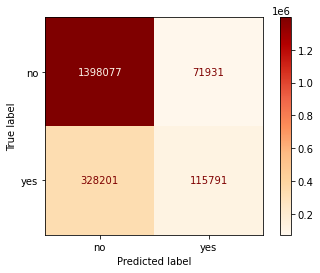

In [23]:
plot_confusion_matrix(log_reg, X_test, y_test, values_format='d', display_labels=['no', 'yes'], cmap="OrRd")
#plot_confusion_matrix(xgb_reg, X_test, y_test, values_format='d', display_labels=['no', 'yes'])

[[1398077   71931]
 [ 328201  115791]]


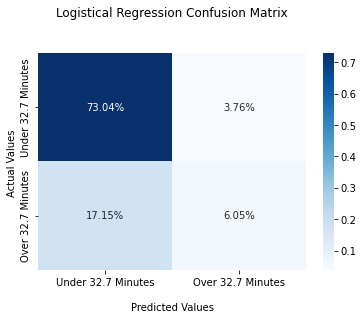

In [29]:
#Generate the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)

print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Logistical Regression Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Under 32.7 Minutes','Over 32.7 Minutes'])
ax.yaxis.set_ticklabels(['Under 32.7 Minutes','Over 32.7 Minutes'])

## Display the visualization of the Confusion Matrix.
plt.show()